# setup

In [1]:
# dependencies
import re
import time
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# support methods
# not convinced this is useful
def supp_datetime(df):
    """
    The filenames in the data are what was scraped from the website.
    These often include the year and month completed.
    We could recover those values from the filenames if needed.
    """
    copy = df.copy()
    re_yyyymo = "[0-9]{4}" + "[" + re.escape("-_") + "]+" + "[0-9]{2}"
    re_yymo = "[^0-9]([0-9]{2}" + "[" + re.escape("-_") + "]+" + "[0-9]{2})"
    copy['filename_yyyymm'] = copy.pdf_file.apply(
        lambda x: "|".join(re.findall(re_yyyymo, x)).replace("_", "-")
        if any(re.findall(re_yyyymo, x)) else None)
    copy['filename_yymm'] = copy.pdf_file.apply(
        lambda x: "|".join(re.findall(re_yymo, x)).replace("_", "-")
        if any(re.findall(re_yymo, x)) else None)
    return copy

In [3]:
# main
dpa = pd.read_parquet("../../export/output/complaints.parquet")

# there are still negative TTC values, but we've fixed about 40 of them
working = dpa.loc[(dpa.date_completed - dpa.date_complained) >= pd.Timedelta(0)].copy()

# overview

In [4]:
basiccols = ['pdf_url', 'pdf_file', 'fileid',
             'complaint_no', 'allegation_no', 'complaint_meta',
             'allegation_text', 'allegations',
             'category_of_conduct', 'finding', 'sustained', 'findings_of_fact',]
othercols = ['fileid'] + [col for col in dpa.columns if col not in basiccols]

In [5]:
dpa[basiccols].sample().T

,20683
pdf_url,https://wayback.archive-it.org/org-571/2023012...
pdf_file,output/pdfs/occ-OCC_04_07_openness.pdf
fileid,85039def
complaint_no,32
allegation_no,4
complaint_meta,DATE OF COMPLAINT: 06/29/06 DATE OF COMPLETION...
allegation_text,SUMMARY OF ALLEGATION #4: The officer made ina...
allegations,The officer made inappropriate comments.
category_of_conduct,CRD
finding,No Finding


In [6]:
dpa[[col for col in othercols if dpa[col].dtype == bool]].sum().sort_values(ascending=False)

failed_reqmt             7096
action_wo_cause          6269
inapp_action             6014
force                    3557
bwc                      3210
jlp                      2960
default_finding          2543
unnec_force              2057
detain_wo_cause          1996
malignant_action         1313
withdrawn                1244
arrest_wo_cause          1185
cite_wo_cause            1124
mediated                 1026
firearm                   956
search_wo_cause           935
bias                      757
occ_added                 574
racial_bias               548
resisting                 402
minor                     387
entry_wo_cause            378
dpa_added                 360
dishonesty                241
towed_wo_cause            232
tookproperty_wo_cause     192
pursuit                   157
no_officer_id             116
home                       87
display_weapon             55
crisis                     30
missing_person             26
taser                      18
swat      

# completed before the complaint

In [7]:
dpa.loc[(dpa.date_completed - dpa.date_complained) < pd.Timedelta(0), [
    'fileid', 'complaint_meta', 'date_complained', 'date_completed']]

,fileid,complaint_meta,date_complained,date_completed
62,069120f2,DATE OF COMPLAINT: 08/20/19 D...,2019-08-20,2019-05-20
108,ec4a28d7,DATE OF COMPLAINT: 09/30/20 DA...,2020-09-30,2020-03-23
114,9826cad4,DATE OF COMPLAINT: 07/27/15 DAT...,2016-07-29,2016-06-24
116,a49ece65,DATE OF COMPLAINT: 03/15/19 D...,2019-03-15,2019-01-11
276,d617d579,COMPLAINT DATE: 12/15/22 COMPLETI...,2022-12-15,2022-06-05
...,...,...,...,...
27023,dabfe6da,DATE OF COMPLAINT: 02/07/18 DAT...,2018-02-07,2018-01-24
27302,a49ece65,DATE OF COMPLAINT: 03/15/19 D...,2019-03-15,2019-01-11
27359,30bf2725,DATE OF COMPLAINT: 12/11/17 DATE...,2017-12-11,2017-07-05
27372,30bf2725,DATE OF COMPLAINT: 12/11/17 ...,2017-12-11,2017-07-05


# date range

In [8]:
dpa.date_complained.describe()

count                            25292
mean     2012-08-20 21:24:23.798829824
min                2001-07-17 00:00:00
25%                2007-01-03 00:00:00
50%                2013-09-25 00:00:00
75%                2017-12-22 00:00:00
max                2024-01-24 00:00:00
Name: date_complained, dtype: object

In [9]:
dpa.date_completed.describe()

count                            25262
mean     2013-04-26 09:45:11.329269504
min                2003-12-30 00:00:00
25%                2007-08-23 00:00:00
50%                2014-05-29 00:00:00
75%                2018-07-12 00:00:00
max                2024-02-24 00:00:00
Name: date_completed, dtype: object

# case volume overtime

<Axes: xlabel='year_complained'>

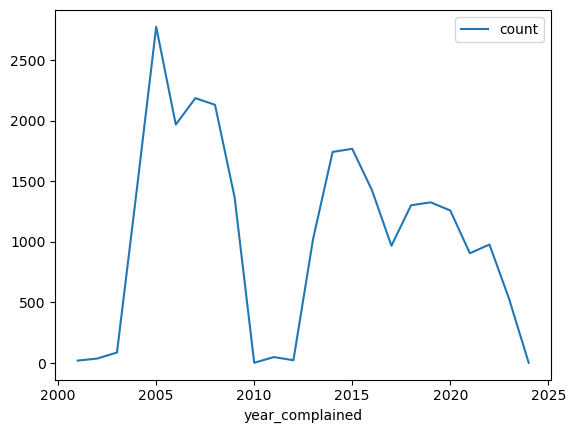

In [10]:
dpa.year_complained.value_counts().sort_index().to_frame().plot()

<Axes: xlabel='year_completed'>

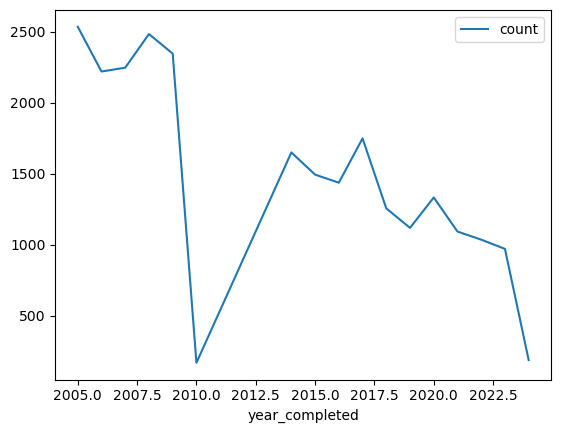

In [11]:
dpa.year_completed.value_counts().sort_index().to_frame().plot()

# time to complete

In [12]:
dpa.ttc_group.value_counts()

ttc_group
6 months to 1 year    12641
3 to 6 months          4569
1 to 3 months          3199
1 to 2 years           3119
Less than 1 month       915
Over 2 years            591
NEGATIVE                206
Name: count, dtype: int64

In [13]:
dpa.loc[(dpa.time_to_complete > pd.Timedelta(0))].time_to_complete.describe()

count                          25026
mean     257 days 10:31:30.194198036
std      206 days 19:17:33.832013244
min                  1 days 00:00:00
25%                130 days 00:00:00
50%                247 days 00:00:00
75%                329 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

In [14]:
working.time_to_complete.describe()

count                          25034
mean     257 days 08:33:02.200207716
std      206 days 19:43:41.609947990
min                  0 days 00:00:00
25%                130 days 00:00:00
50%                247 days 00:00:00
75%                329 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

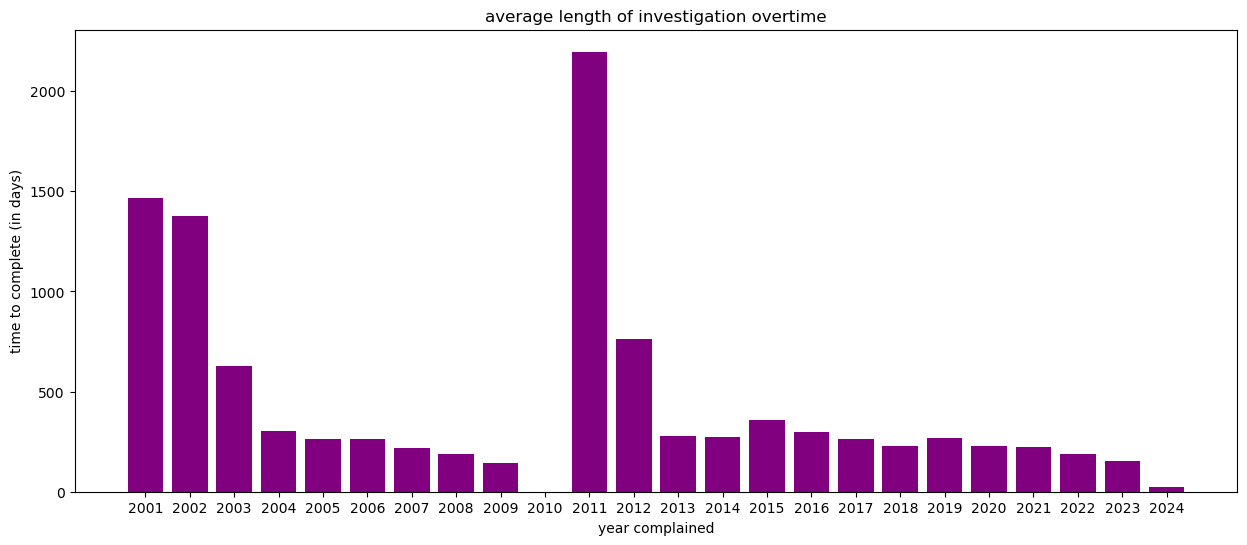

In [15]:
ttc_vc = working[['year_complained', 'time_to_complete']].groupby('year_complained').mean().sort_index().reset_index()
x = ttc_vc.year_complained.astype(int).astype(str).values
y = ttc_vc.time_to_complete.dt.days.values

fig= plt.figure(figsize=(15,6))
plt.title("average length of investigation overtime")
plt.xlabel("year complained")
plt.ylabel("time to complete (in days)")
plt.bar(x,y, label='', color='purple')
plt.show()

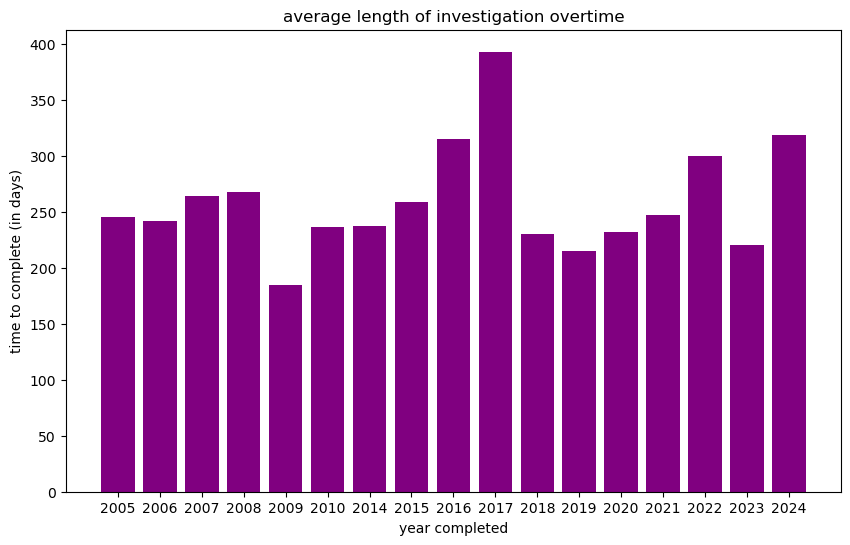

In [16]:
ttc_vc = working[['year_completed', 'time_to_complete']].groupby('year_completed').mean().sort_index().reset_index()
x = ttc_vc.year_completed.astype(int).astype(str).values
y = ttc_vc.time_to_complete.dt.days.values

fig= plt.figure(figsize=(10,6))
plt.title("average length of investigation overtime")
plt.xlabel("year completed")
plt.ylabel("time to complete (in days)")
plt.bar(x,y, label='', color='purple')
plt.show()

# what else

In [17]:
working[['complaint_id', 'allegation_id',
         'dpa_added', 'finding', 'sustained']].sort_values('complaint_id')

,complaint_id,allegation_id,dpa_added,finding,sustained
14452,00fc1c4c_0,85e770dc8e43e57e,False,NS,False
27119,00fc1c4c_1,fb30ec31430edf9f,False,Unfounded,False
18877,00fc1c4c_10,ae9c3c44e44152ec,False,NS,False
9122,00fc1c4c_10,555b31a96e610ad5,False,NS,False
2678,00fc1c4c_10,1942976b1a7dd0e5,False,NS,False
...,...,...,...,...,...
5263,fc5c93ad_9,3176f837e4187b26,False,Withdrawn,False
19281,fc5c93ad_9,b24a5a86f3d3b9b9,False,Withdrawn,False
7983,fc5c93ad_9,4aca6f322c46e755,False,Withdrawn,False
24479,fc5c93ad_9,e2e75874335f4ec9,False,Withdrawn,False


In [18]:
working.sustained.value_counts()

sustained
False    23417
True      1617
Name: count, dtype: int64

In [19]:
working[['occ_added', 'sustained']].value_counts()

occ_added  sustained
False      False        23073
           True          1389
True       False          344
           True           228
Name: count, dtype: int64

In [20]:
working[['dpa_added', 'sustained']].value_counts()

dpa_added  sustained
False      False        23275
           True          1420
True       True           197
           False          142
Name: count, dtype: int64

In [21]:
working.mediated.value_counts()

mediated
False    24015
True      1019
Name: count, dtype: int64

In [22]:
working.force.value_counts()

force
False    21522
True      3512
Name: count, dtype: int64

In [23]:
working.jlp.value_counts()

jlp
False    22149
True      2885
Name: count, dtype: int64

In [24]:
working.default_finding.value_counts()

default_finding
False    22507
True      2527
Name: count, dtype: int64

# mediation and withdrawal trends

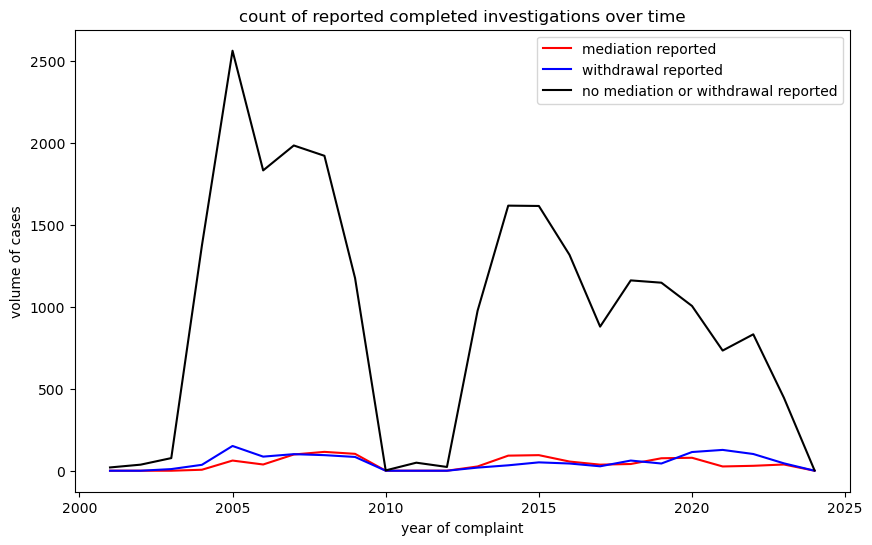

In [25]:
test = working[['year_complained', 'mediated', 'withdrawn']
    ].groupby('year_complained').value_counts().to_frame().reset_index()
x = sorted(test.year_complained.unique())
y = {str(int(year)):
     test.loc[(test.year_complained == year) & (test.mediated),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()
y2 = {str(int(year)):
     test.loc[(test.year_complained == year) & (test.withdrawn),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()
y3 = {str(int(year)):
     test.loc[(test.year_complained == year) & (~(test.mediated | test.withdrawn)),
     'count'].sum() for year in sorted(test.year_complained.unique())
    }.values()

fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x, y, label='mediation reported', color='red')
plt.plot(x, y2, label='withdrawal reported', color='blue')
plt.plot(x, y3, label='no mediation or withdrawal reported', color='black')
plt.title("count of reported completed investigations over time")
plt.xlabel("year of complaint")
plt.ylabel("volume of cases")
ax.legend(loc='upper right')
plt.show()

# topic plotting

In [26]:
# borrowed from us-ii-mp
# needs reworking for this data
def add_dist_plot(recent_hilo_tidy, dists, axs, i):
    dist_df = recent_hilo_tidy.loc[recent_hilo_tidy.city_district_occurred == dists[i]]
    for (report_type, color) in (('notification', 'gold'),
                                 ('arrival', 'red'),
                                 ('closure', 'purple')):
        y = dist_df.loc[dist_df.report_type == report_type
            ].sort_values('year_occurred')['report_rate(%)'].values
        axs[i].plot(x, y, color=color, label=report_type)
        axs[i].set_title(f"District {dists[i]}\n", fontweight='bold')
        axs[i].set_ylabel("proportion of cases\nwith timestamp\n")
        axs[i].legend(loc="upper right")
    return True

In [27]:
group1 = [
    'intimidation',
    'jlp',
    'resisting',
    'force',
    'pursuit',
    'swat',
    'firearm',
    'taser',]
group2 = [
    'jlp',
    'racial_bias',
    'home',
    'missing_person',
    'minor',
    'crisis',]
group3 = [
    ('force', 'jlp'),
    ('bwc', 'jlp'),
    ('firearm', 'jlp'),]

In [28]:
dpa[[
    'intimidation', 'jlp', 'racial_bias', 'resisting', 'force',
    'bwc', 'pursuit', 'swat', 'firearm', 'taser',
    'home', 'missing_person', 'minor', 'crisis',]].sum()

intimidation         8
jlp               2960
racial_bias        548
resisting          402
force             3557
bwc               3210
pursuit            157
swat                18
firearm            956
taser               18
home                87
missing_person      26
minor              387
crisis              30
dtype: int64

# exploring common words

In [29]:
colsadded = [
    'action_wo_cause',
    'entry_wo_cause', 'search_wo_cause', 'towed_wo_cause', 'tookproperty_wo_cause',
    'cite_wo_cause', 'detain_wo_cause', 'arrest_wo_cause',
    'display_weapon', 'unnec_force', 'malignant_action',
    'dishonesty', 'bias',
    'inapp_action', 'failed_reqmt',
]

In [30]:
dpa.loc[~dpa[colsadded].apply(any, axis=1), 'allegations'].shape[0]

1903

In [31]:
dpa[colsadded].sum().sort_values(ascending=False)

failed_reqmt             7096
action_wo_cause          6269
inapp_action             6014
unnec_force              2057
detain_wo_cause          1996
malignant_action         1313
arrest_wo_cause          1185
cite_wo_cause            1124
search_wo_cause           935
bias                      757
entry_wo_cause            378
dishonesty                241
towed_wo_cause            232
tookproperty_wo_cause     192
display_weapon             55
dtype: int64

# top 5

In [32]:
top5cols = dpa[colsadded].sum().sort_values(ascending=False).head(5).index.values
top5cols

array(['failed_reqmt', 'action_wo_cause', 'inapp_action', 'unnec_force',
       'detain_wo_cause'], dtype=object)

In [33]:
for col in top5cols:
    print(col)
    count = dpa[col].sum()
    topallegs = dpa.loc[dpa[col], 'allegations'].value_counts().head(10)
    for v,c in topallegs.items(): print(f"{v}:\t{c}")
    print()

failed_reqmt
The officer failed to take required action.:	1201
The officers failed to take required action.:	499
The officer failed to properly investigate.:	360
The officers failed to properly investigate.:	209
The officer failed to properly process property.:	192
The officer failed to write an incident report.:	99
The officer failed to properly supervise.:	84
The officer failed to take the required action.:	79
The officer prepared an incomplete or inaccurate incident report.:	60
The officer failed to take a required action.:	59

action_wo_cause
The officer detained the complainant without justification.:	532
The officer issued a citation without cause.:	527
The officer arrested the complainant without cause.:	450
The officers detained the complainant without justification.:	375
The officers arrested the complainant without cause.:	262
The officer cited the complainant without cause.:	243
The officer handcuffed the complainant without justification.:	178
The officer searched the compl

In [34]:
nottop5 = list(set(colsadded).difference(set(top5cols)))
n_nottop5 = dpa.loc[dpa[nottop5].apply(any, axis=1), 'allegations'].shape[0]
f"{round(n_nottop5/dpa.shape[0]*100, 1)
}% of the allegations are not represented by the top5 types of alleged misconduct"

'24.4% of the allegations are not represented by the top5 types of alleged misconduct'

In [35]:
n_nottop5 = dpa.loc[~(dpa.failed_reqmt | dpa.action_wo_cause | dpa.inapp_action |
          dpa.unnec_force | dpa.detain_wo_cause), 'allegations'].shape[0]
f"{round(n_nottop5/dpa.shape[0]*100, 1)}% of the allegations are not represented by the top5 types of alleged misconduct"

'15.6% of the allegations are not represented by the top5 types of alleged misconduct'

```{note}
Which one of the above statements is right? Why are those calculations different?
```

In [36]:
dpa.loc[~(dpa.failed_reqmt | dpa.action_wo_cause | dpa.inapp_action |
          dpa.unnec_force | dpa.detain_wo_cause), [
    'unnec_force', 'malignant_action', 'dishonesty', 'bias']].value_counts()

unnec_force  malignant_action  dishonesty  bias 
False        False             False       False    1903
             True              False       False    1064
             False             False       True      729
                               True        False     239
             True              False       True       14
Name: count, dtype: int64

# category of conduct

### --> what does "CRD" stand for?

In [37]:
dpa.category_of_conduct.fillna("MISSING LABEL").value_counts()

category_of_conduct
Neglect of Duty                  7492
Unwarranted Action               7434
CRD                              5331
Unnecessary Force                2110
Conduct Unbecoming an Officer    1406
Discourtesy                       642
MISSING LABEL                     642
Sexual Slur                       122
Racial Slur                       108
Policy or Procedure                21
NA                                  6
NS                                  4
XXX                                 2
MANDATE                             2
T                                   1
N                                   1
PPC                                 1
IE                                  1
U                                   1
Name: count, dtype: int64

In [38]:
dpa.loc[~(dpa.failed_reqmt | dpa.action_wo_cause | dpa.inapp_action |
          dpa.unnec_force | dpa.detain_wo_cause), [
    'category_of_conduct', 'finding']].value_counts()

category_of_conduct            finding         
CRD                            NS                  886
Conduct Unbecoming an Officer  Unfounded           230
CRD                            Unfounded           229
Unwarranted Action             Proper Conduct      178
                               NS                  167
                                                  ... 
Policy or Procedure            No Finding            1
                               Withdrawn             1
Racial Slur                    Mediated              1
Sexual Slur                    Mediated              1
Neglect of Duty                Training Failure      1
Name: count, Length: 80, dtype: int64

In [39]:
dpa.loc[dpa.category_of_conduct == 'CRD', colsadded].sum().sort_values(ascending=False)

inapp_action             3755
malignant_action          858
bias                      531
dishonesty                163
action_wo_cause            39
failed_reqmt               28
unnec_force                 5
arrest_wo_cause             4
tookproperty_wo_cause       2
search_wo_cause             1
entry_wo_cause              0
towed_wo_cause              0
cite_wo_cause               0
detain_wo_cause             0
display_weapon              0
dtype: int64

In [40]:
dpa.loc[dpa.category_of_conduct == 'CRD', 'allegation_text'].sample().values

array(['SUMMARY OF ALLEGATION #1: The officer made threatening and inappropriate remarks to the complainant. CATEGORY OF CONDUCT: CRD                  FINDING: PC          DEPT. ACTION: FINDINGS OF FACT: The officer denied the allegation and stated the complainant was told what the lawful consequences of his continued actions would be. The evidence proved that the acts, which provided the basis for the allegations, occurred, however, such acts were justified, lawful and proper.'],
      dtype=object)

In [41]:
dpa.loc[dpa.category_of_conduct == 'CRD', 'allegation_text'].sample().values

array(['SUMMARY OF ALLEGATION #1-4: The officers made inappropriate and threatening remarks. CATEGORY OF CONDUCT: CRD                 FINDING: NS               DEPT. ACTION: FINDINGS OF FACT: The complainant stated the officers laughed at him and did not allow him to make his contentions during the tow hearing. The officers denied they laughed at the complainant. The officers stated the complainant was argumentative and disruptive. There was no witness that provided a tatement at this time. There was insufficient evidence to prove or disprove the allegation made in the complaint.'],
      dtype=object)

In [42]:
dpa.loc[(dpa.category_of_conduct.isna()),
'allegation_text'].sample().values

array(['SUMMARY OF ALLEGATION#: CATEGORY OF CONDUCT               FINDING:            DEPT. ACTION: FINDINGS OF FACT:                                   OFFICE OF CITIZEN COMPLAINTS'],
      dtype=object)